In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# df = pd.read_csv('../auto-seg-bias/data/nnunet700+_hnscc_metrics.csv', index_col=0)

# sensitive_feats = ['Gender', 'HPV Status']
# df = df[df['HPV Status'] != 'Unknown']

df = pd.read_csv('../auto-seg-bias/data/radcure_nnunet_with_clinical.csv', index_col=0)
df = df[df['OAR'] == 'Brainstem']
sensitive_feats = ['Chemo? ', 'HPV']

df['HPV'] = df['HPV'].replace({'Yes, positive': 'HPV_+', 'Yes, Negative': 'HPV_-'})
df['Chemo? '] = df['Chemo? '].replace({'Yes':'Chemo_yes', 'none': 'Chemo_no'})
df = df.dropna(subset=['HPV'])

# df = pd.read_csv('../auto-seg-bias/data/nnunet700+_quebec_metrics_with_clinical.csv', index_col=0)

# sensitive_feats = ['Sex', 'HPV status']
# df['HPV status'] = df['HPV status'].replace({'+': 'P', '-': 'N'})
# df['Sex'] = df['Sex'].replace({'M': 'Male', 'F': 'Female'})
# df = df.dropna(subset=['HPV status'])



In [21]:
# Create new categorical feature combining Gender and HPV Status
df['Chemo_HPVs'] = df[sensitive_feats].astype(str).agg('|'.join, axis=1)

# Display unique values to check the new feature
print(df['Chemo_HPVs'].unique())


['Chemo_yes|HPV_+' 'Chemo_yes|HPV_-' 'Chemo_no|HPV_+' 'Chemo_no|HPV_-']


In [30]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal

def generate_violin(
        sensitive_features: pd.DataFrame,
        endpoint: pd.Series,
        output_dir: Path | str,
        show_figure: bool = True, 
        save_figure = True, 
        tag: str = '',
    ) -> None:
    """
    Generates violin plots to visualize the distribution of `endpoint` across `sensitive_features`.

    This function creates violin plots for each feature in `sensitive_features` to compare the 
    distribution of `endpoint` across different groups. The plots are saved in `output_dir`.

    Args:
        sensitive_features (pd.DataFrame): DataFrame containing categorical sensitive features.
        endpoint (pd.Series): Series representing the bias metric or outcome variable.
        output_dir (Path | str): Directory where plots should be saved.
        show_figure (bool, optional): Whether to display the figure. Defaults to True.
        save_figure (bool, optional): Whether to save the figure. Defaults to True.
        tag (str, optional): Optional tag for filename customization. Defaults to ''.

    Returns:
        None
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for feature_name, feature_series in sensitive_features.items():
        plt.figure(figsize=(8, 6)) 
        sns.set_theme(style="whitegrid")  

        sns.violinplot(
            x=feature_series, 
            y=endpoint, 
            palette="muted",  
            inner="point", 
            linewidth=1.25 
        )

        # Perform statistical test based on number of unique groups
        unique_groups = feature_series.dropna().unique()

        if len(unique_groups) == 2:
            # Mann-Whitney U Test (for 2 groups)
            group_1 = endpoint[feature_series == unique_groups[0]]
            group_2 = endpoint[feature_series == unique_groups[1]]

            if len(group_1) > 1 and len(group_2) > 1:
                u_stat, p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
                test_text = f"p-value: {p_value:.4f}"
            else:
                test_text = ""

        elif len(unique_groups) > 2:
            # Kruskal-Wallis H Test (for 3+ groups)
            group_data = [endpoint[feature_series == group] for group in unique_groups]

            if all(len(g) > 1 for g in group_data):  # Ensure all groups have at least 2 values
                h_stat, p_value = kruskal(*group_data)
                test_text = f"p-value: {p_value:.4f}"
            else:
                test_text = ""

        else:
            test_text = ""

        # Add p-value as text on the plot
        plt.text(0.05, 0.95, test_text, transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


        title_tag = f" ({tag})" if tag else ""
        filename_tag = f"_{tag}" if tag else ""

        plt.title(f'{endpoint.name} Distribution by {feature_name} {title_tag}', fontsize=16, weight='bold')  
        plt.xlabel(f'{feature_name}', fontsize=14)  
        plt.ylabel(f'{endpoint.name} per Patient', fontsize=14) 
        plt.xticks(rotation=45, ha='right')

        plt.ylim(0, 5000)

        plt.tight_layout()
        
        if save_figure:
            plt.savefig(output_dir / f'{feature_name}_vs_{endpoint.name}{filename_tag}.png')  
        if show_figure:
            plt.show()

In [7]:
df = pd.read_csv('../auto-seg-bias/data/radcure_nnunet_with_clinical.csv', index_col=0)
df = df[df['OAR'] == 'Brainstem']
sensitive_feats = ['Smoking Status', 'HPV']

df['Chemo? '] = df['Chemo? '].replace({'Yes':'Chemo_yes', 'none': 'Chemo_no'})
df['HPV'] = df['HPV'].replace({'Yes, positive': 'HPV_+', 'Yes, Negative': 'HPV_-'})
df = df.dropna(subset=['HPV'])
df = df[df['Smoking Status'] != 'unknown']


In [8]:
# Create new categorical feature combining Gender and HPV Status
df['HPVs_SmokingStatus'] = df[sensitive_feats].astype(str).agg('|'.join, axis=1)

# Display unique values to check the new feature
print(df['HPVs_SmokingStatus'].unique())

['Ex-smoker|HPV_+' 'Non-smoker|HPV_-' 'Non-smoker|HPV_+' 'Current|HPV_+'
 'Ex-smoker|HPV_-' 'Current|HPV_-']


/tmp/ipykernel_39137/3694293396.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


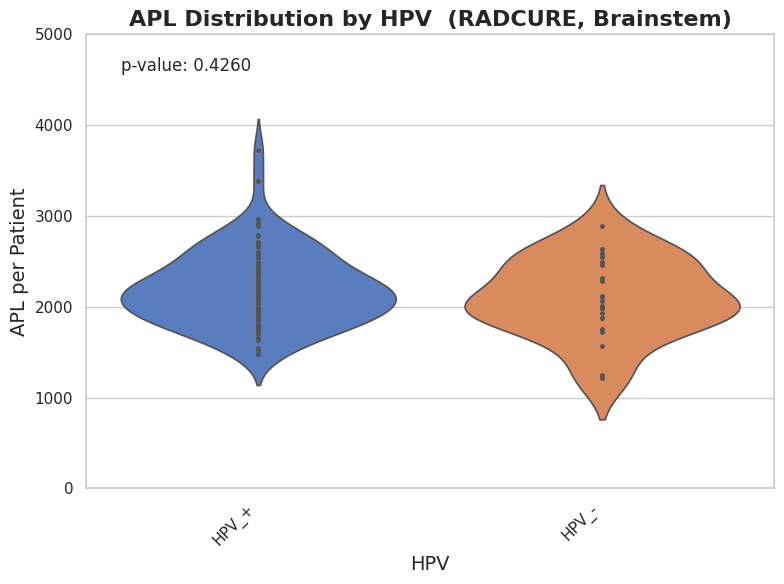

In [37]:
generate_violin(df[['HPV']], df['APL'], '.', save_figure=False, tag='RADCURE, Brainstem')

/tmp/ipykernel_8980/2833767465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive['Age'] = pd.cut(df_sensitive['Age'], bins=bins, labels=labels, right=True)


In [20]:
import statsmodels.api as sm
from typing import Tuple
from tabulate import tabulate
from pathlib import Path

def subgroup_analysis_OLS(
        sensitive_features: pd.DataFrame,
        endpoint: pd.Series,
        output_dir: Path | str,
        print_report: bool = True, 
        save_report: bool = True,
    ) -> Tuple[sm.OLS, float]:
    """
    Performs Ordinary Least Squares (OLS) regression to analyze the relationship between 
    `sensitive_features` and `endpoint`.

    This function fits an OLS model using one-hot encoded `sensitive_features` to predict `endpoint`. 
    If the overall model p-value is < 0.05, a detailed report is printed and optionally saved.

    Args:
        sensitive_features (pd.DataFrame): DataFrame containing categorical sensitive features.
        endpoint (pd.Series): Series representing the target variable (bias metric).
        output_dir (Path | str): Directory to save the regression report.
        print_report (bool, optional): Whether to print the report. Defaults to True.
        save_report (bool, optional): Whether to save the report. Defaults to True.

    Returns:
        Tuple[sm.OLS, float] The fitted OLS model and the model's F-statistic p-value.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    feature_names = sensitive_features.columns

    one_hot_encoded = pd.get_dummies(
        sensitive_features[feature_names], 
    )
    X_columns = one_hot_encoded.columns

    X = one_hot_encoded.values  
    y = endpoint.values  

    X = sm.add_constant(X.astype(float), has_constant='add')
    model = sm.OLS(y, X).fit()

    p_value = model.f_pvalue

    # if p_value < 0.05 and (print_report or save_report):

    print(model.summary(xname=['const'] + X_columns.tolist()))

    for x, y in zip(['const'] + X_columns.tolist(), model.pvalues):
        print(f'{x}: {y}')

        # output = []

        # print(f"⚠️  **Possible Bias Detected in {feature_names}** ⚠️\n")
        # output.append(f"=== Subgroup Analysis for '{feature_names}' Using OLS Regression ===\n")

        # output.append("Model Statistics:")
        # output.append(f"    R-squared:                  {model.rsquared:.3f}")
        # output.append(f"    F-statistic:                {model.fvalue:.3f}")
        # output.append(f"    F-statistic p-value:        {p_value:.4f}")
        # output.append(f"    AIC:                        {model.aic:.2f}")
        # output.append(f"    Log-Likelihood:             {model.llf:.2f}")

        # summary_df = pd.DataFrame({
        #     'Feature': ['const'] + X_columns.tolist(),     # Predictor names (includes 'const' if added)
        #     'Coefficient': model.params,    # Coefficients
        #     'Standard Error': model.bse     # Standard Errors
        # })
        # table_output = tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".3f")
        # output.append("Model Coefficients:")
        # output.append('\n'.join(['    ' + line for line in table_output.split('\n')]))

        # output_text = '\n'.join(output)

        # if print_report:
        #     print(output_text)
        
        # if save_report:
        #     with open(output_dir / f'{'_'.join(feature_names)}_OLS_summary.txt', 'w') as f:
        #         f.write(output_text)

    return model, p_value

In [5]:
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df = pd.read_csv('./data/radcure_nnunet_with_clinical.csv', index_col=0)
# df_sensitive = df[['OAR', 'Sex', 'Age', 'Ds Site', 'Stage', 'HPV', 'N', 'T', 'Chemo? ', 'Smoking Status', 'APL']]
sensitive_feats = ['OAR', 'Sex', 'Age', 'Ds Site', 'Stage', 'HPV', 'N', 'T', 'Chemo? ', 'Smoking Status', 'APL']

bins = [0, 40, 60, 80, float('inf')]
labels = ["≤40", "41-60", "61-80", "80+"]

# Apply categorization
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# df = pd.read_csv('./data/nnunet700+_quebec_metrics_with_clinical.csv', index_col=0)

# sensitive_feats = ['Sex', 'Age', 'Primary Site', 'T-stage', 'N-stage', 'M-stage', 'TNM group stage', 'HPV status']

# bins = [0, 40, 60, 80, float('inf')]
# labels = ["≤40", "41-60", "61-80", "80+"]
# df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# df = pd.read_csv('../auto-seg-bias/data/nnunet700+_hnscc_metrics.csv', index_col=0)

# sensitive_feats = ['Gender', 'Age at Diag', 'Smoking status', 'HPV Status', 'T-category', 'N-category', 'AJCC Stage (7th edition)']

# bins = [0, 40, 60, 80, float('inf')]
# labels = ["≤40", "41-60", "61-80", "80+"]
# df['Age at Diag'] = pd.cut(df['Age at Diag'], bins=bins, labels=labels, right=True)

_df = df[df["OAR"] == 'Brainstem']



In [21]:
model, _ = subgroup_analysis_OLS(df[['HPVs_SmokingStatus']], df['APL'], save_report=False, output_dir='.')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     4.421
Date:                Tue, 04 Mar 2025   Prob (F-statistic):            0.00109
Time:                        12:25:56   Log-Likelihood:                -808.18
No. Observations:                 110   AIC:                             1628.
Df Residuals:                     104   BIC:                             1645.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [18]:
pvalues = model.pvalues

# Print the p-values with their corresponding features
for feature, pvalue in pvalues.items():
    print(f'Feature: {feature}, p-value: {pvalue}')

AttributeError: 'numpy.ndarray' object has no attribute 'items'